## Import

In [ ]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, EarlyStoppingCallback
import evaluate
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
import warnings

In [112]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## import der gelablten daten und testsplit

Gelabelte Daten importieren und mergen

In [114]:
# CSV-Dateien laden und vereinheitlichen
df_posts_old = pd.read_csv("labeled_posts.csv").rename(columns={"post_id": "id"})
df_comments_old = pd.read_csv("labeled_comments.csv").rename(columns={"comment_id": "id"})
df_new_posts = pd.read_csv("labeled_post.csv").rename(columns={"post_id": "id"})
df_new_comments = pd.read_csv("labeled_comment.csv").rename(columns={"comment_id": "id"})

# Alle 4 Datasets zusammenfassen → 600 Samples
df_all_labeled = pd.concat([df_posts_old, df_comments_old, df_new_posts, df_new_comments], ignore_index=True)
df_all_labeled = df_all_labeled[['id', 'text', 'label']].dropna()
df_all_labeled['label'] = pd.to_numeric(df_all_labeled['label'], errors='coerce')
df_all_labeled = df_all_labeled.dropna(subset=['label'])
df_all_labeled['label'] = df_all_labeled['label'].astype(int)

print(f"✅ Gesamtdatensatz mit {len(df_all_labeled)} gelabelten Beispielen bereit.")

✅ Gesamtdatensatz mit 574 gelabelten Beispielen bereit.


train test split

In [115]:
# 📌 Ziel: alle Daten nur zum Testen verwenden
df_balanced_test = df_all_labeled.copy()

# 🔍 Anzeigen
print(df_balanced_test["label"].value_counts())

# Ausgabe
print(f"\n📊 Verteilung:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(df_balanced_test)}")


label
1    300
0    186
2     88
Name: count, dtype: int64

📊 Verteilung:
Train: 344 | Val: 115 | Test: 574


## de Berta Modell testen

In [116]:
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# Hugging Face Dataset-Objekt erzeugen
test_dataset = Dataset.from_pandas(df_balanced_test)

# Tokenisierung
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_test = tokenized_test.rename_column("label", "labels")
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Map: 100%|██████████| 574/574 [00:00<00:00, 4551.26 examples/s]


In [117]:
from transformers import AutoModelForSequenceClassification, Trainer

model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=3)

trainer = Trainer(model=model, tokenizer=tokenizer)
predictions = trainer.predict(tokenized_test)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hp\AppData\Local\Temp\ipykernel_15672\3824315709.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


In [118]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("🔍 Accuracy:", accuracy_score(y_true, y_pred))
print("🔍 F1 (macro):", f1_score(y_true, y_pred, average="macro"))
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred))


🔍 Accuracy: 0.5226480836236934
🔍 F1 (macro): 0.2288329519450801
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.52      1.00      0.69       300
           2       0.00      0.00      0.00        88

    accuracy                           0.52       574
   macro avg       0.17      0.33      0.23       574
weighted avg       0.27      0.52      0.36       574



c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## ElKulako/cryptobert

In [119]:

# CryptoBERT laden
model_name = "ElKulako/cryptobert"
cryptobert_tokenizer = AutoTokenizer.from_pretrained(model_name)
cryptobert_model = AutoModelForSequenceClassification.from_pretrained(model_name)
cryptobert_model.eval()

# Texte & Labels aus test_dataset extrahieren
texts = test_dataset['text']
true_labels = test_dataset['label']

# Vorhersagen
preds = []
for text in texts:
    inputs = cryptobert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        logits = cryptobert_model(**inputs).logits
    pred_id = torch.argmax(logits, dim=1).item()
    preds.append(pred_id)

# Label-Mapping anpassen: CryptoBERT: 0=neg, 1=neutral, 2=pos → Wir: bearish=2, neutral=1, bullish=0
crypto_to_our = {2: 0, 1: 1, 0: 2}
mapped_preds = [crypto_to_our[p] for p in preds]

acc_elkulako = accuracy_score(true_labels, mapped_preds)
f1_elkulako = f1_score(true_labels, mapped_preds, average="macro")

print(f"📊 CryptoBERT (ElKulako) — Accuracy: {acc_elkulako:.4f}, F1: {f1_elkulako:.4f}")


📊 CryptoBERT (ElKulako) — Accuracy: 0.4756, F1: 0.4071


## Vader

In [120]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, f1_score

# Init
vader = SentimentIntensityAnalyzer()

vader_preds = []
for text in test_dataset['text']:
    score = vader.polarity_scores(text)['compound']
    if score >= 0.05:
        vader_preds.append(0)  # bullish
    elif score <= -0.05:
        vader_preds.append(2)  # bearish
    else:
        vader_preds.append(1)  # neutral

# Evaluation
true_labels = test_dataset['label']
acc_vader = accuracy_score(true_labels, vader_preds)
f1_vader = f1_score(true_labels, vader_preds, average="macro")

print(f"📊 VADER — Accuracy: {acc_vader:.4f}, F1: {f1_vader:.4f}")

📊 VADER — Accuracy: 0.3728, F1: 0.3732


## Textblob (Spacy)

In [121]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score, f1_score

# Klassische Schwellen für Sentiment
textblob_preds = []

for text in test_dataset['text']:
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity >= 0.05:
        textblob_preds.append(0)  # bullish
    elif polarity <= -0.05:
        textblob_preds.append(2)  # bearish
    else:
        textblob_preds.append(1)  # neutral

# Evaluation
true_labels = test_dataset['label']
acc_blob = accuracy_score(true_labels, textblob_preds)
f1_blob = f1_score(true_labels, textblob_preds, average="macro")

print(f"📊 TextBlob (Englisch) — Accuracy: {acc_blob:.4f}, F1: {f1_blob:.4f}")

📊 TextBlob (Englisch) — Accuracy: 0.4077, F1: 0.3602


## Plot

In [122]:
plot_results_data = {
    "CryptoBERT": {
        "accuracy": acc_elkulako,
        "f1": f1_elkulako
    },
    "VADER": {
        "accuracy": acc_vader,
        "f1": f1_vader
    },
    "TextBlob": {
        "accuracy": acc_blob,
        "f1": f1_blob
    }
}


In [123]:
def plot_results(results_dict):
    models = list(results_dict.keys())
    accuracy = [results_dict[m]["accuracy"] for m in models]
    f1 = [results_dict[m]["f1"] for m in models]

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, accuracy, width, label="Accuracy")
    plt.bar(x + width/2, f1, width, label="F1-Score")

    plt.xticks(x, models)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("🔎 Modellvergleich auf dem Testset")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_15672\1458932060.py:19: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


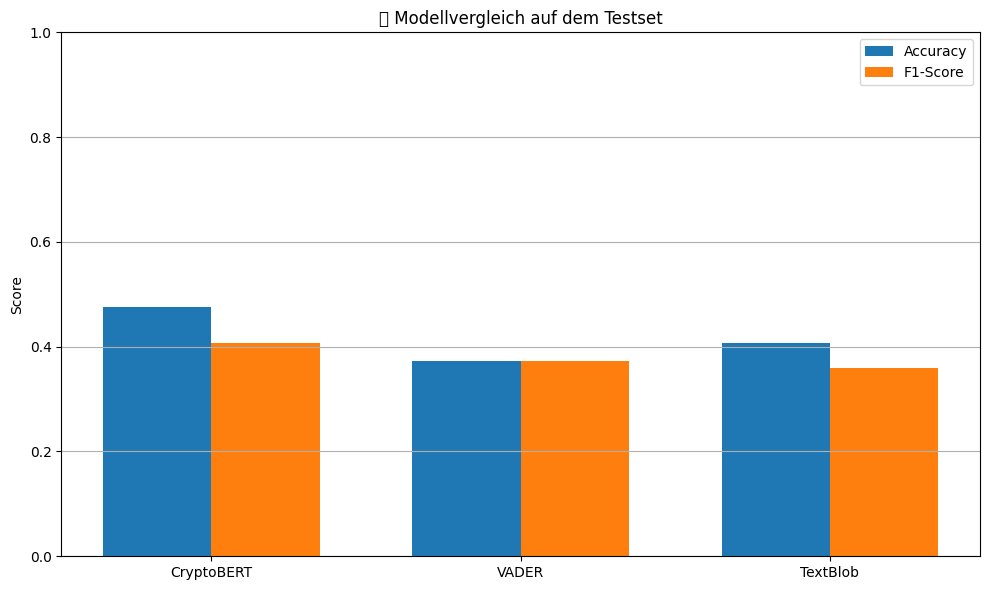

In [124]:
plot_results(plot_results_data)


## Elkulako verbessern

### split

In [ ]:
trainval_df, test_df = train_test_split(
    df_balanced_test,
    test_size=0.2,
    stratify=df_balanced_test["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.25,
    stratify=trainval_df["label"],
    random_state=42
)

# Index resetten!
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [183]:
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print("Train labels:\n", train_df["label"].value_counts())


Train size: 344
Val size: 115
Test size: 115
Train labels:
 label
1    180
0    112
2     52
Name: count, dtype: int64


Modell und Tokenizer laden

In [184]:
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


Tokenisierung der Splits

In [185]:
# Tokenisierung
train_ds = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_ds = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

# Format setzen – Korrekt pro Dataset!
train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 115/115 [00:00<00:00, 5887.21 examples/s]


Metriken

In [ ]:
print(train_ds)

Dataset({
    features: ['id', 'text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 344
})


In [187]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }


Trainingsargumente & Trainer

In [188]:
results = {}  # Lernkurven für jede Lernrate
lrs = [2e-5, 1e-5, 5e-6]

for lr in lrs:
    print(f"🚀 Starte Training für learning_rate = {lr}")

    training_args = TrainingArguments(
        output_dir=f"./cryptobert_lr_{lr}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_dir=f"./logs_lr_{lr}",
        logging_strategy="epoch",
        report_to="none",
        remove_unused_columns=False,
        disable_tqdm=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    start = time.time()
    trainer.train()
    end = time.time()

    # Lernkurve extrahieren
    logs = trainer.state.log_history
    epoch_logs = [log for log in logs if "eval_f1" in log]
    df = pd.DataFrame(epoch_logs)[["epoch", "eval_f1"]]
    df["learning_rate"] = lr

    # Speichern mit allen nötigen Infos
    results[lr] = {
        "f1_curve": df,
        "best_f1": df["eval_f1"].max(),
        "trainer": trainer
    }


c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_15672\799026861.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Starte Training für learning_rate = 2e-05
{'loss': 1.3739, 'grad_norm': 27.83279037475586, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}
{'eval_loss': 1.0163160562515259, 'eval_accuracy': 0.5652173913043478, 'eval_f1': 0.38657476775546895, 'eval_runtime': 0.9198, 'eval_samples_per_second': 125.031, 'eval_steps_per_second': 16.308, 'epoch': 1.0}
{'loss': 0.624, 'grad_norm': 28.87763786315918, 'learning_rate': 1.2e-05, 'epoch': 2.0}
{'eval_loss': 1.2704827785491943, 'eval_accuracy': 0.6, 'eval_f1': 0.39999999999999997, 'eval_runtime': 0.9254, 'eval_samples_per_second': 124.264, 'eval_steps_per_second': 16.208, 'epoch': 2.0}
{'loss': 0.3941, 'grad_norm': 45.612064361572266, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}
{'eval_loss': 1.3392959833145142, 'eval_accuracy': 0.5652173913043478, 'eval_f1': 0.47684232866425047, 'eval_runtime': 0.9338, 'eval_samples_per_second': 123.157, 'eval_steps_per_second': 16.064, 'epoch': 3.0}
{'loss': 0.2632, 'grad_norm': 24.153764724731

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_15672\799026861.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.1302, 'grad_norm': 23.699016571044922, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.0}
{'eval_loss': 1.6285017728805542, 'eval_accuracy': 0.5217391304347826, 'eval_f1': 0.3981119005042449, 'eval_runtime': 0.9725, 'eval_samples_per_second': 118.256, 'eval_steps_per_second': 15.425, 'epoch': 1.0}
{'loss': 0.0437, 'grad_norm': 0.3931768536567688, 'learning_rate': 6e-06, 'epoch': 2.0}
{'eval_loss': 1.6369959115982056, 'eval_accuracy': 0.5739130434782609, 'eval_f1': 0.48276624839124843, 'eval_runtime': 1.011, 'eval_samples_per_second': 113.753, 'eval_steps_per_second': 14.837, 'epoch': 2.0}
{'loss': 0.017, 'grad_norm': 2.4304847717285156, 'learning_rate': 4.000000000000001e-06, 'epoch': 3.0}
{'eval_loss': 1.706132411956787, 'eval_accuracy': 0.5739130434782609, 'eval_f1': 0.48341473341473334, 'eval_runtime': 1.0456, 'eval_samples_per_second': 109.981, 'eval_steps_per_second': 14.345, 'epoch': 3.0}
{'loss': 0.0078, 'grad_norm': 3.138075590133667, 'learning_rate': 2.0000000000

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_15672\799026861.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.0029, 'grad_norm': 1.772976279258728, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.0}
{'eval_loss': 1.9120861291885376, 'eval_accuracy': 0.6, 'eval_f1': 0.48726817042606513, 'eval_runtime': 1.0184, 'eval_samples_per_second': 112.927, 'eval_steps_per_second': 14.73, 'epoch': 1.0}
{'loss': 0.0015, 'grad_norm': 0.035229507833719254, 'learning_rate': 3e-06, 'epoch': 2.0}
{'eval_loss': 2.047548294067383, 'eval_accuracy': 0.6, 'eval_f1': 0.5319193971721278, 'eval_runtime': 1.0598, 'eval_samples_per_second': 108.513, 'eval_steps_per_second': 14.154, 'epoch': 2.0}
{'loss': 0.0007, 'grad_norm': 0.043558523058891296, 'learning_rate': 2.0000000000000003e-06, 'epoch': 3.0}
{'eval_loss': 2.1264901161193848, 'eval_accuracy': 0.5739130434782609, 'eval_f1': 0.486566924066924, 'eval_runtime': 1.0389, 'eval_samples_per_second': 110.692, 'eval_steps_per_second': 14.438, 'epoch': 3.0}
{'loss': 0.0009, 'grad_norm': 0.05738835409283638, 'learning_rate': 1.0000000000000002e-06, 'epoch': 4.0}

PLott fuer die Lernrate

C:\Users\hp\AppData\Local\Temp\ipykernel_15672\2650982940.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


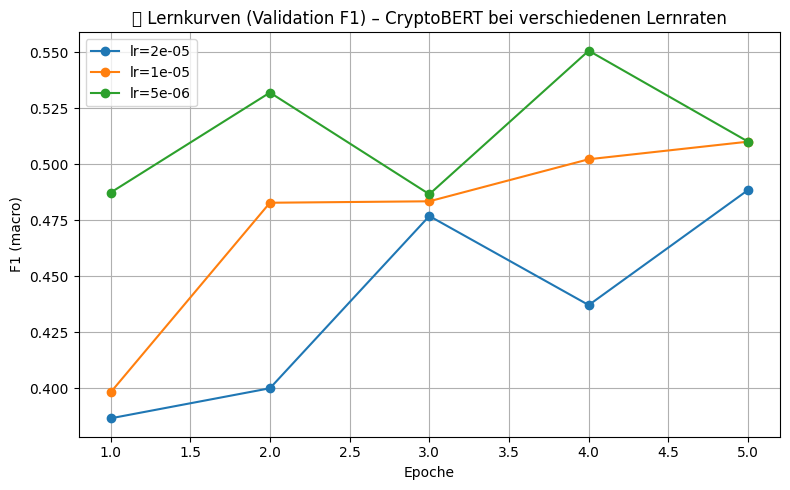

In [ ]:
plt.figure(figsize=(8, 5))

for lr, data in results.items():
    df = data["f1_curve"]
    plt.plot(df["epoch"], df["eval_f1"], marker="o", label=f"lr={lr}")

plt.title("📈 Lernkurven (Validation F1) – CryptoBERT bei verschiedenen Lernraten")
plt.xlabel("Epoche")
plt.ylabel("F1 (macro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [191]:
# Beste Lernrate bestimmen
best_lr = max(results.items(), key=lambda x: x[1]["best_f1"])[0]
best_trainer = results[best_lr]["trainer"]

print(f"\n🏆 Beste Lernrate: {best_lr} mit F1 = {results[best_lr]['best_f1']:.4f}")



🏆 Beste Lernrate: 5e-06 mit F1 = 0.5506


Evaualation auf dem finalen Testset

In [192]:
test_results = best_trainer.predict(test_ds)

from sklearn.metrics import classification_report
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_results.label_ids

print("\n📊 Evaluation auf Testset:")
print(classification_report(y_true, y_pred))



📊 Evaluation auf Testset:
              precision    recall  f1-score   support

           0       0.44      0.49      0.46        37
           1       0.61      0.62      0.61        60
           2       0.31      0.22      0.26        18

    accuracy                           0.51       115
   macro avg       0.45      0.44      0.44       115
weighted avg       0.51      0.51      0.51       115



In [ ]:
wrong = [(i, p, t) for i, (p, t) in enumerate(zip(y_pred, y_true)) if p != t]
wrong_df = test_df.iloc[[i for i, _, _ in wrong]].copy()
wrong_df["predicted"] = [p for _, p, _ in wrong]
wrong_df["true"] = [t for _, _, t in wrong]

wrong_df[["text", "true", "predicted"]].head(10)


,text,true,predicted
1,Favourite ALTS for 2025? There's been much tal...,0,1
2,Would you take 100% chance of getting 600k or ...,0,1
4,bahhahahha,1,0
5,India Strikes Crypto Exchange Bybit: Major Fin...,2,0
6,Traditional Investments v. Bitcoin The way I s...,0,1
7,"Bitcoin maxi posted ""Solana will be the first ...",0,1
14,Trip Report: Struggles of a new crypto user Hi...,2,1
17,"**Historical Bitcoin prices for today, Decembe...",1,0
18,!topics,1,0
19,Bitcoin surpasses 100k! New ath of 101.5k what...,1,0
